In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f, te, l
from sklearn.metrics import mean_squared_error
import math

In [20]:
BASEPATH = 'C:\SuryaMain\Python Projects\Chinook-Growth-Project'
SIMULATION_BASEPATH = os.path.join(BASEPATH, "simulate_nonlinear_data")
datasets = [name for name in os.listdir(SIMULATION_BASEPATH) if name[0:4] == 'data'] 
    
def get_data(fname):
    path = os.path.join(SIMULATION_BASEPATH, fname)
    if os.path.exists(path):
        X = pd.read_csv(os.path.join(path, 'X.csv'))
        X.drop(X.columns[0], axis=1, inplace=True)
        y = pd.read_csv(os.path.join(path, 'y.csv'))
        y.drop(y.columns[0], axis=1, inplace=True)
        return [X, y]
    else: 
        print("Dataset does not exist")
        return [0,0]
        
class SimGAM:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.model = None
        
    def train_lgam(self, **kwargs):
        gam = LinearGAM(**kwargs).fit(self.X, self.y)
        lams = []
        if 'lam' in kwargs.keys():
            lams = kwargs.get('lam')
        else:
            lams = np.logspace(-5,5,20)*len(self.X.columns)
        gam.gridsearch(self.X, self.y, lam=lams)
        self.model = gam

    def pdp(self, nrows, ncols):
        if self.model is not None: 
            fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
            titles = list(map(lambda x:f'V{x}', np.arange(1,len(self.X.columns)+1)))
            for i, ax in enumerate(axs):
                XX = self.model.generate_X_grid(term=i) 
                ax.plot(XX[:, i], self.model.partial_dependence(term=i, X=XX))
                ax.plot(XX[:, i], self.model.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
                ax.set_title(titles[i]);
                ax.grid(True)
            plt.suptitle('Partial Dependence', size=16)
            fig.tight_layout()
            plt.show()
        else: 
            print("Model Has Not Been Trained")

    def calc_aic(self):
        if self.model is not None:
            num_params = len(self.model.coef_) + 1
            aic = -2*self.model.loglikelihood(self.X,self.y) + 2*num_params
            return aic
        else: 
            print("Model Has Not Been Trained")
            return 0.0

100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


AIC: 30.40285375093721


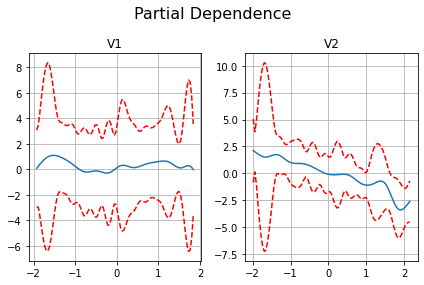

In [21]:
dataset_1 = get_data('data_set_1')
X = dataset_1[0]
y = dataset_1[1]
gam = SimGAM(X, y)
gam.train_lgam(n_splines=16)
aic = gam.calc_aic()
print(f'AIC: {aic}')
gam.pdp(nrows=1, ncols=2)

In [ ]:
def main():
    aic_dict = {}
    for dataset in datasets[0:10]:
        dst = get_data(dataset)
        X = dst[0]
        y = dst[1]
        gam = SimGAM(X,y)
        gam.train_lgam(n_splines=15)
        aic = gam.calc_aic()
        aic_dict[dataset] = aic
    return aic_dict

aics = main()

In [10]:
aics

{'data_set_1': 224.96677796285633,
 'data_set_10': -203.52783008046083,
 'data_set_100': -371.65823665439086,
 'data_set_101': -210.23879580893157,
 'data_set_102': 346.11310539521145,
 'data_set_103': -51.97903947269032,
 'data_set_104': 94.2971310102175,
 'data_set_105': -364.64452260351766,
 'data_set_107': -121.4978938683551,
 'data_set_108': 400.60365465828426}